# Centrifugal Pump (CP)
March 9th, 2025
Data analysis by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

In [892]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.stats import linregress
import math
import warnings
warnings.filterwarnings('ignore')

### Reading in Data from .csv

In [893]:
df = pd.read_csv("MW1-Centrifugal Pump Lab Raw Data - Sheet1.csv")

In [894]:
df

,inner_diam,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp
0,0.4,3.500,50,2907.8,778.1,139,134,280,2.20,1.3,5.50,5.00,21.50,12.897850,8963.184464,37921.16504,1.842550,0.214250
1,0.4,3.500,40,2317.5,778.1,139,107,280,1.89,1.7,5.00,3.20,19.00,11.398100,11721.087380,34473.78640,1.628300,0.171400
2,0.4,3.500,30,1717.9,778.1,139,81,280,1.38,2.1,4.25,2.00,17.00,10.198300,14478.990290,29302.71844,1.456900,0.557050
3,0.4,3.500,20,1120.2,778.1,138,54,280,1.10,2.5,4.00,1.00,10.50,6.298950,17236.893200,27579.02912,0.899850,0.299950
4,0.4,3.500,10,519.2,778.1,138,22,280,0.80,2.6,3.50,0.95,7.00,4.199300,17926.368930,24131.65048,0.599900,NaN
5,0.5,4.500,50,2770.0,667.4,140,130,300,3.60,1.0,6.80,10.50,28.00,16.797200,6894.757280,46884.34950,2.399600,0.171400
6,0.5,4.500,40,2252.0,667.4,140,105,290,2.62,1.1,5.80,7.00,26.00,15.597400,7584.233008,39989.59222,2.228200,0.449925
7,0.5,4.500,30,1673.5,667.4,140,80,290,1.90,1.7,5.00,4.00,20.75,12.447925,11721.087380,34473.78640,1.778275,0.535625
8,0.5,4.500,20,1074.8,667.4,140,50,285,1.30,2.4,4.00,2.00,14.50,8.698550,16547.417470,27579.02912,1.242650,1.156950
9,0.5,4.500,10,487.8,667.4,140,25,285,1.00,2.6,4.00,1.00,1.00,0.599900,17926.368930,27579.02912,0.085700,NaN


### Pre-Processing

Converting our flow rate to a volumetric flow rate in m^3 / sec:

$$ \text{flow rate in } \frac{\text{gallon}}{\text{min}} = \frac{6.309 \times 10^-5 \text{cubic meters}}{\text{gallon}} \times \frac{\text{1 min}}{\text{60 sec}}$$

In [895]:
df["volumetric_flowrate"] = df["flow_rate"] * 6.309 * 10 ** -5 * (1 / 60) # m^3/s

converting inches to meters

$$ 39.37 \ \text{in} = 1 \ \text{m}$$

In [896]:
df["impeller_diam_meters"] = df["impeller_diam"] * (1/39.37)
df["inner_diam_meters"] = df["inner_diam"] * (1/39.37)

In [897]:
df

,inner_diam,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,...,drive_shaft_torque,flowrate_percentage,flow_rate,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp,volumetric_flowrate,impeller_diam_meters,inner_diam_meters
0,0.4,3.500,50,2907.8,778.1,139,134,280,2.20,1.3,...,5.00,21.50,12.897850,8963.184464,37921.16504,1.842550,0.214250,1.356209e-05,0.088900,0.01016
1,0.4,3.500,40,2317.5,778.1,139,107,280,1.89,1.7,...,3.20,19.00,11.398100,11721.087380,34473.78640,1.628300,0.171400,1.198510e-05,0.088900,0.01016
2,0.4,3.500,30,1717.9,778.1,139,81,280,1.38,2.1,...,2.00,17.00,10.198300,14478.990290,29302.71844,1.456900,0.557050,1.072351e-05,0.088900,0.01016
3,0.4,3.500,20,1120.2,778.1,138,54,280,1.10,2.5,...,1.00,10.50,6.298950,17236.893200,27579.02912,0.899850,0.299950,6.623346e-06,0.088900,0.01016
4,0.4,3.500,10,519.2,778.1,138,22,280,0.80,2.6,...,0.95,7.00,4.199300,17926.368930,24131.65048,0.599900,NaN,4.415564e-06,0.088900,0.01016
5,0.5,4.500,50,2770.0,667.4,140,130,300,3.60,1.0,...,10.50,28.00,16.797200,6894.757280,46884.34950,2.399600,0.171400,1.766226e-05,0.114300,0.01270
6,0.5,4.500,40,2252.0,667.4,140,105,290,2.62,1.1,...,7.00,26.00,15.597400,7584.233008,39989.59222,2.228200,0.449925,1.640067e-05,0.114300,0.01270
7,0.5,4.500,30,1673.5,667.4,140,80,290,1.90,1.7,...,4.00,20.75,12.447925,11721.087380,34473.78640,1.778275,0.535625,1.308899e-05,0.114300,0.01270
8,0.5,4.500,20,1074.8,667.4,140,50,285,1.30,2.4,...,2.00,14.50,8.698550,16547.417470,27579.02912,1.242650,1.156950,9.146525e-06,0.114300,0.01270
9,0.5,4.500,10,487.8,667.4,140,25,285,1.00,2.6,...,1.00,1.00,0.599900,17926.368930,27579.02912,0.085700,NaN,6.307949e-07,0.114300,0.01270


## Analysis Question 1
$$ \textbf {For one impeller, plot head versus capacity with rotational speed as a parameter (See
references for determining head and capacity.)} $$

We measure experimental head through our rotameters which we see in the df as head_exp. We see in additional resources that this head-capacity plot is shown as 

$$ \Delta  \text{H vs q}  $$

Now let's plot this pump head against capacity which we know is the same as head-flowrate (McCabe-Smith, 202)

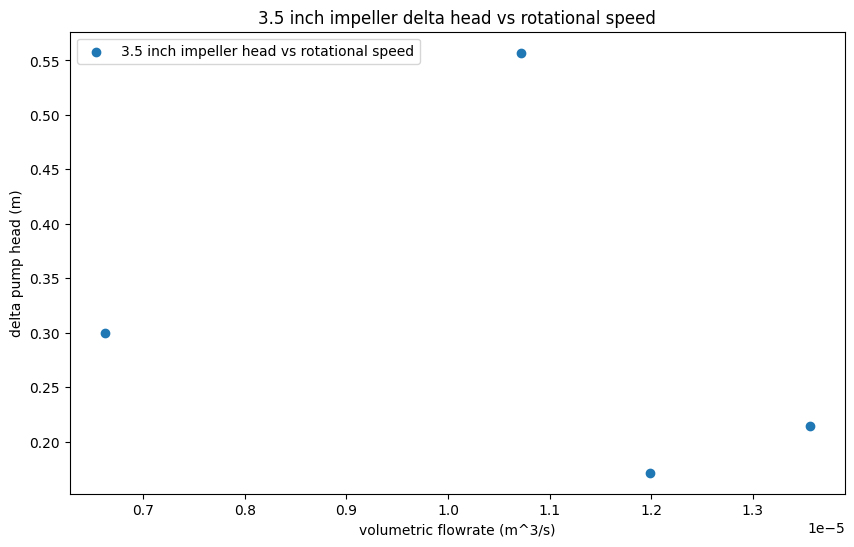

In [898]:
df_small = df.query("impeller_diam == 3.500")

plt.figure(figsize=(10,6))
plt.scatter(df_small["volumetric_flowrate"], df_small["delta_head_exp"], marker="o", label="3.5 inch impeller head vs rotational speed")
plt.xlabel("volumetric flowrate (m^3/s)")
plt.ylabel("delta pump head (m)")
plt.title("3.5 inch impeller delta head vs rotational speed")
plt.legend()

Let's plot the rest of the impeller sizes to ensure that this is the correct shape we should be looking for

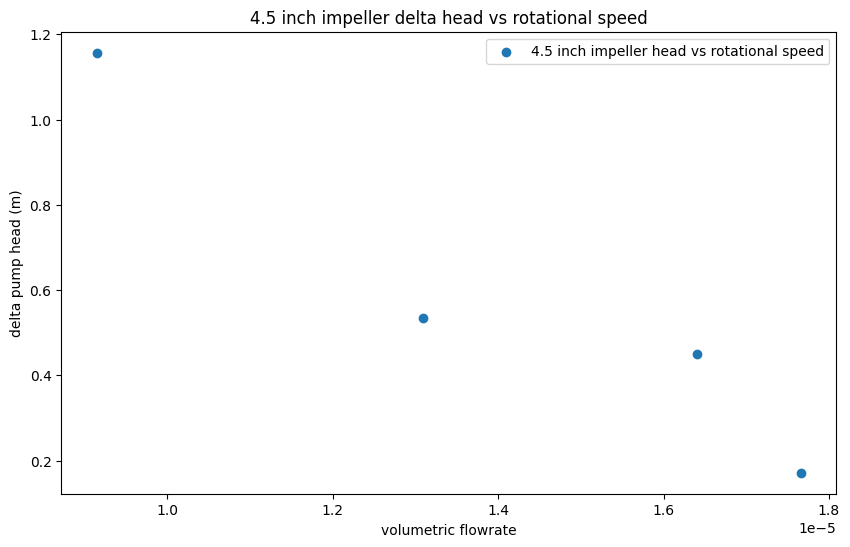

In [899]:
df_med = df.query("impeller_diam == 4.500")

plt.figure(figsize=(10,6))
plt.scatter(df_med["volumetric_flowrate"], df_med["delta_head_exp"], marker="o", label="4.5 inch impeller head vs rotational speed")
plt.xlabel("volumetric flowrate")
plt.ylabel("delta pump head (m)")
plt.title("4.5 inch impeller delta head vs rotational speed")
plt.legend()

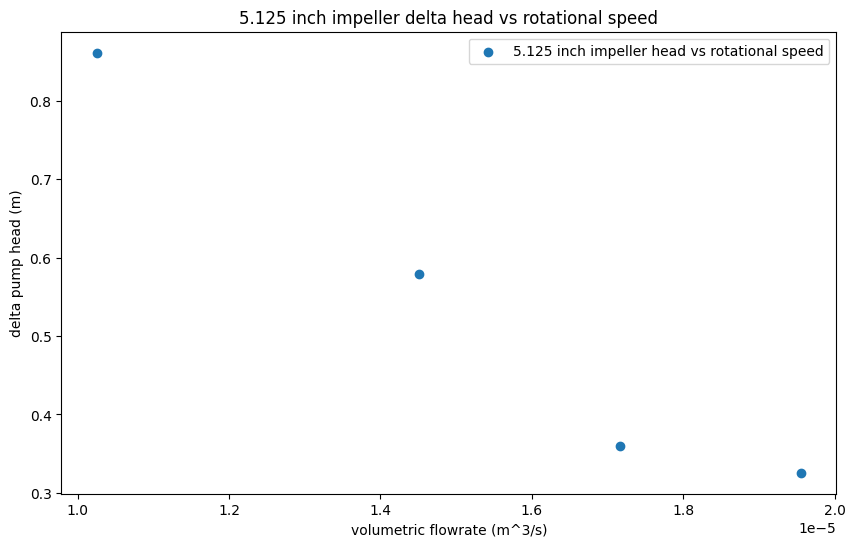

In [900]:
df_big = df.query("impeller_diam == 5.125")

plt.figure(figsize=(10,6))
plt.scatter(df_big["volumetric_flowrate"], df_big["delta_head_exp"], marker="o", label="5.125 inch impeller head vs rotational speed")
plt.xlabel("volumetric flowrate (m^3/s)")
plt.ylabel("delta pump head (m)")
plt.title("5.125 inch impeller delta head vs rotational speed")
plt.legend()

Now, we have a good sense of the shape, it is best reprsented by the 5.125 inch impeller so we will use this going forward. Let's synthesize a quantitative relationship that describes effect of rotational speed on head. The relationship appears polynomial, so we can fit a polynomial regression to this line. 

In [901]:
impeller_size = 4.500
subset = df[df["impeller_diam"] == impeller_size]

subset.dropna(inplace=True)

X = subset[["ext_fpm"]].values  # Rotational speed (N)
y = subset["delta_head_exp"].values  # Pump head (H)

In [902]:
X_quad = np.hstack((X, X**2))
model = LinearRegression()
model.fit(X_quad, y)

a, b = model.coef_[1], model.coef_[0]
c = model.intercept_

X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_fit_quad = np.hstack((X_fit, X_fit**2))
y_fit = model.predict(X_fit_quad)


In [903]:
def cubic(N, a, b, c, d):
    return a * N**3 + b * N**2 + c * N + d

popt_cubic, _ = curve_fit(cubic, X.flatten(), y)
y_fit_cubic = cubic(X_fit.flatten(), *popt_cubic)


ADD ERROR BARS

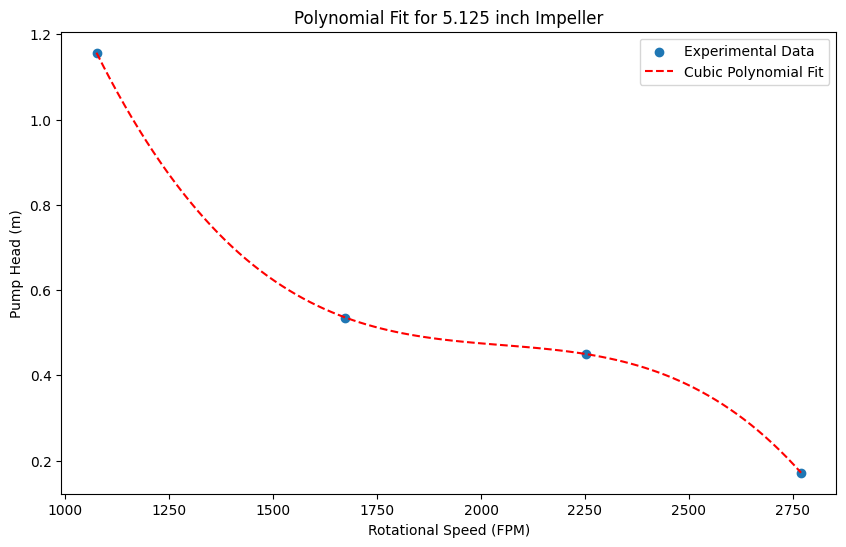

'Poly Fit Eqn = -6.553802e-10N³ + 4.032830e-06N² + -8.349849e-03N + 6.286384e+00'

In [904]:
plt.figure(figsize=(10,6))
plt.scatter(X, y, label="Experimental Data")
plt.plot(X_fit, y_fit_cubic, label="Cubic Polynomial Fit", color="red", linestyle="--")
plt.xlabel("Rotational Speed (FPM)")
plt.ylabel("Pump Head (m)")
plt.title(f"Polynomial Fit for {5.125} inch Impeller")
plt.legend()
plt.show()

cubic_eq = f"Poly Fit Eqn = {popt_cubic[0]:.6e}N³ + {popt_cubic[1]:.6e}N² + {popt_cubic[2]:.6e}N + {popt_cubic[3]:.6e}"

cubic_eq


So, we can synthesize a head(fpm) expression of 

$$
h(fpm) = -0.00000000192 fpm^{3} + 0.00000206 fpm^{2} -0.0000217 fpm + 0.00024
$$

We can also plot using a physical law like the head equation from (Noel de Nevers, 373) which we will denote as (1.1). Note that we will neglect as a necessary assumption. An additional assumption we make is the choice of velocities since we are restricted to inner an outter .

(1.1):
$$ H =  \frac{\omega ^ 2}{g} (r_3 ^ 2 - r_2 ^ 2) + \frac{V_2 ^ 2 - V_3 ^ 2}{2g}$$

This provides H as a function of angular velocity 

$$ H \approx f(\omega) $$

## Analysis Question 2

$$ \textbf{Prepare a plot of head as a function of capacity for a single rpm.} $$

motor speed and RPM are analagous so we will partition our dataframe on 50 V motor speed

In [948]:
df_50 = df.query("motor_speed == 30")

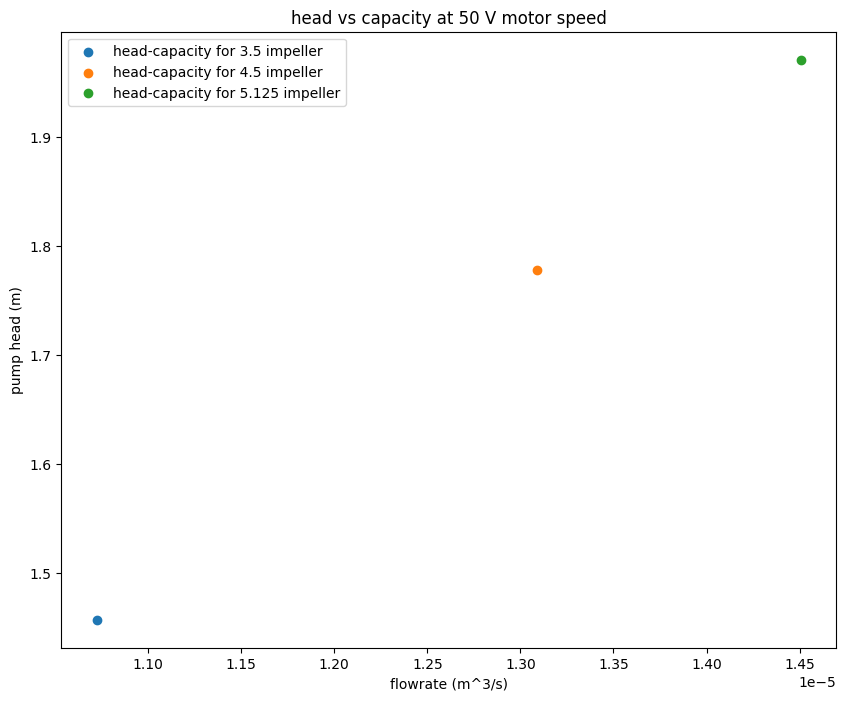

In [951]:
plt.figure(figsize=(10,8))
for diam in df["impeller_diam"].unique():
    df_diam = df_50.query("impeller_diam == @diam")
    plt.title("head vs capacity at 50 V motor speed")
    plt.scatter(df_diam["volumetric_flowrate"], df_diam["head_exp"], marker="o", label = f"head-capacity for {diam} impeller")
    plt.legend()
    plt.xlabel("flowrate (m^3/s)")
    plt.ylabel("pump head (m)")

$$ \textbf{Describe qualitatively the effect of impeller diameter on the
head-capacity relationship.}$$

$$\textbf{Can you describe this relationship quantitatively?}
$$

This shows that as you increase diameter, the flow rate AND pump head increase for a given RPM. To describe this quantitatively, we reference the below equation (2.1):

$$ \Delta H_r = \frac{u_2(u_2-q_r/A_p tan \beta_2)}{g_c} $$

where A_p is shown as:

$$ A_p = pi * \frac{\text{diameter}}{2} * L$$

So this is a quantitative relationship that describes head as a function of diameter and flow rate:

$$ H \approx f(q, rpm)$$

(McCabe-Smith, 200)

## Analysis Question 3
$$ \textbf{For the larger impeller at the highest speed, plot the
observed head versus}$$

$$ \textbf{capacity and the relationship predicted by the analysis of the
ideal pump} $$

We start by finding the ideal pump head-capacity relationship which is given by the equation at (Noel de Nevers, 373)

(3.1):
$$ \Delta H_{ideal} = \frac{\omega ^ 2}{g} (r_3^2 - r_2 ^2) + \frac{V_1^2 - V_4^2}{2g}$$


we have all of these values except for u_2 which is the peripheral velocity, which is defined as:

(3.2):
$$ u_r = r_{impeller} \times \omega $$ 

So, we need to get angular velocity (omega) in rad/s using torque through the below relationship:

(3.3):
$$ \omega = \frac{2\pi (fpm)}{60}$$ 



Now we can use this angular velocity and inner, outter diameters to compute the velocities 2 and 3 given the below expression

$$ v = \omega * r$$

In [ ]:
g = 9.81 # m/s^2
rho = 997 # kg/m^3

df["angular_velocity_ext"] = df["ext_fpm"] * (2 * np.pi / 60)
df["angular_velocity_int"] = df["int_fpm"] * (2 * np.pi / 60)

df["outter_velocity"] = df["angular_velocity_ext"] * df["impeller_diam_meters"]/2
df["inner_velocity"] = df["angular_velocity_int"] * df["inner_diam_meters"]/2

df["head_ideal"] = (((df["angular_velocity_ext"] ** 2)/(g)) * ((df["impeller_diam_meters"]/2) ** 2 - (df["inner_diam_meters"]/2) ** 2) + ((df["inner_velocity"] ** 2) - (df["outter_velocity"] ** 2)) / (2 * g))

df["delta_head_ideal"] = df["head_ideal"].diff()

df_big = df.query("impeller_diam == 5.125")

df_big

plt.figure(figsize=(10,6))
plt.plot(df_big["angular_velocity_ext"][1:], df_big["delta_head_ideal"][1:], marker="o")
plt.xlabel("angular velocity (rad/s)")
plt.ylabel("delta head (m)")

In [ ]:
int_diam = 0.5 * 0.0254 # inch to meters

In [ ]:
df["angular_velocity"] = (2 * np.pi * df["ext_fpm"]) / 60 # rad /s # 3.3

In [ ]:
df["peripheral_velocity"] = df["angular_velocity_ext"] * (df["impeller_diam_meters"] / 2) # m/s # 3.2

In [ ]:
# df["ideal_pump_head"] = ((df["angular_velocity_ext"] ** 2) / g) * (df["impeller_diam_meters"] ** 2 - int_diam ** 2) + (df["int_velocity"] ** 2 - df["peripheral_velocity"] ** 2)/(2*g)

In [ ]:
df

In [ ]:
for diam in df["impeller_diam"].unique():
    df_diam = df.query("impeller_diam == @diam")    
    plt.figure(figsize=(10,6))
    plt.xlabel("flowrate (m^3/s)")
    plt.ylabel("pump head (m)")
    plt.plot(df_diam["volumetric_flowrate"], df_diam["ideal_pump_head"], marker="o", label="ideal pump head vs rotational speed")
    plt.plot(df_diam["volumetric_flowrate"], df_diam["pump_head"], marker="o", label="experimental pump head vs rotational speed")
    plt.legend()
    plt.show()

THIS IS INCORRECT

### Analysis Question 4

$$ \textbf{For a single impeller size,
plot dimensionless head as a function of dimensionless flow for all speeds using the
non-dimensional groups of Streeter.} $$

From Streeter, we can see that the head coefficient is given by:
$$ \psi = \frac{gH}{\omega^2D^2} $$
and the dimensionless correlation for flow is given by:

$$ \phi = \frac{Q}{\omega D^3} $$


for H we will use the ideal H expression given as
$$ \Delta H_r = \frac{u_2(u_2-q_r/A_p tan \beta_2)}{g_c} $$

Let's add the angle data for each impeller from the lab manual

In [ ]:
def get_beta(diam):
    if diam == 3.500:
        return 17
    elif diam == 4.500:
        return 20
    elif diam == 5.125:
        return 19

In [ ]:
df["beta"] = df["impeller_diam"].apply(get_beta)
df["beta_rad"] = df["beta"] * (np.pi / 180)

In [ ]:
df["peripheral_area"] = 2 * np.pi * (df["impeller_diam_meters"] / 2) * df["impeller_width_meters"]

In [ ]:
df["ideal_pump_head_corr"] = (df["peripheral_velocity"] * (df["peripheral_velocity"] - (df["volumetric_flowrate"] / (df["peripheral_area"]) * np.tan(df["beta_rad"])))) / g # 3.1
df["dimensionless_head"] = (g * df["ideal_pump_head_corr"]) / ((df["angular_velocity_ext"] ** 2) * (df["impeller_diam_meters"] ** 2))
df["dimensionless_flow"] = df["volumetric_flowrate"] / (df["angular_velocity_ext"] * (df["impeller_diam_meters"] ** 3))

In [ ]:
for diam in df["impeller_diam"].unique():
    df_diam = df.query("impeller_diam == @diam")
    plt.figure(figsize=(10,6))
    plt.xlabel("dimensionless flow (unitless)")
    plt.ylabel("dimensionless head (unitless)")
    plt.scatter(df_diam["dimensionless_flow"], df_diam["dimensionless_head"], marker="o", label=f"{diam} inch impeller head-capacity")
    plt.legend()

    slope, intercept, _, _, _ = linregress(df_diam["dimensionless_flow"], df_diam["dimensionless_head"])
    plt.plot(df_diam["dimensionless_flow"], slope * df_diam["dimensionless_flow"] + intercept, label=f"linear fit for {diam} inch impeller", color="red", linestyle="--")
    plt.show()

## Analysis Question 5
$$ \textbf{For each speed, prepare a plot of dimensionless head as a function of dimensionless
capacity for different impeller sizes.} $$

In [ ]:
for speed in df["motor_speed"].unique():
    df_speed = df.query("motor_speed == @speed")
    plt.figure(figsize=(10,6))
    plt.xlabel("dimensionless flow")
    plt.ylabel("dimensionless head")
    plt.plot(df_speed["dimensionless_flow"], df_speed["dimensionless_head"], marker="o", label=f"{speed} V rpm impeller head-capacity")
    plt.legend()
    plt.show()

$$ \textbf{Identify data
points on this plot by the impeller size for which they were taken.}$$
$$ \textbf{Do you see three
distinct curves, one for each impeller? Is there a consistent effect of impeller diameter?}$$

DO IN ORPT